# classfication

# 准备数据

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from deeplearing_model import train_model,ModelSaver,EarlyStopping,evaluate
from deeplearing_model import plot_learning_curves,plot_learning_loss_curves

# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([transforms.ToTensor()])#ToTensor将数据转换为张量，并归一化到0-1之间
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_dataset[0]
train_dataset[0][0].shape #1*28*28的ndarray

torch.Size([1, 28, 28])

In [2]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [3]:
# 获取图像和标签
train_images = train_dataset.data.numpy() 
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称，0-9修改为英文
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")
train_images[0] #28*28的ndarray

train_labels[0:5]

训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000


array([9, 0, 0, 3, 0], dtype=int64)

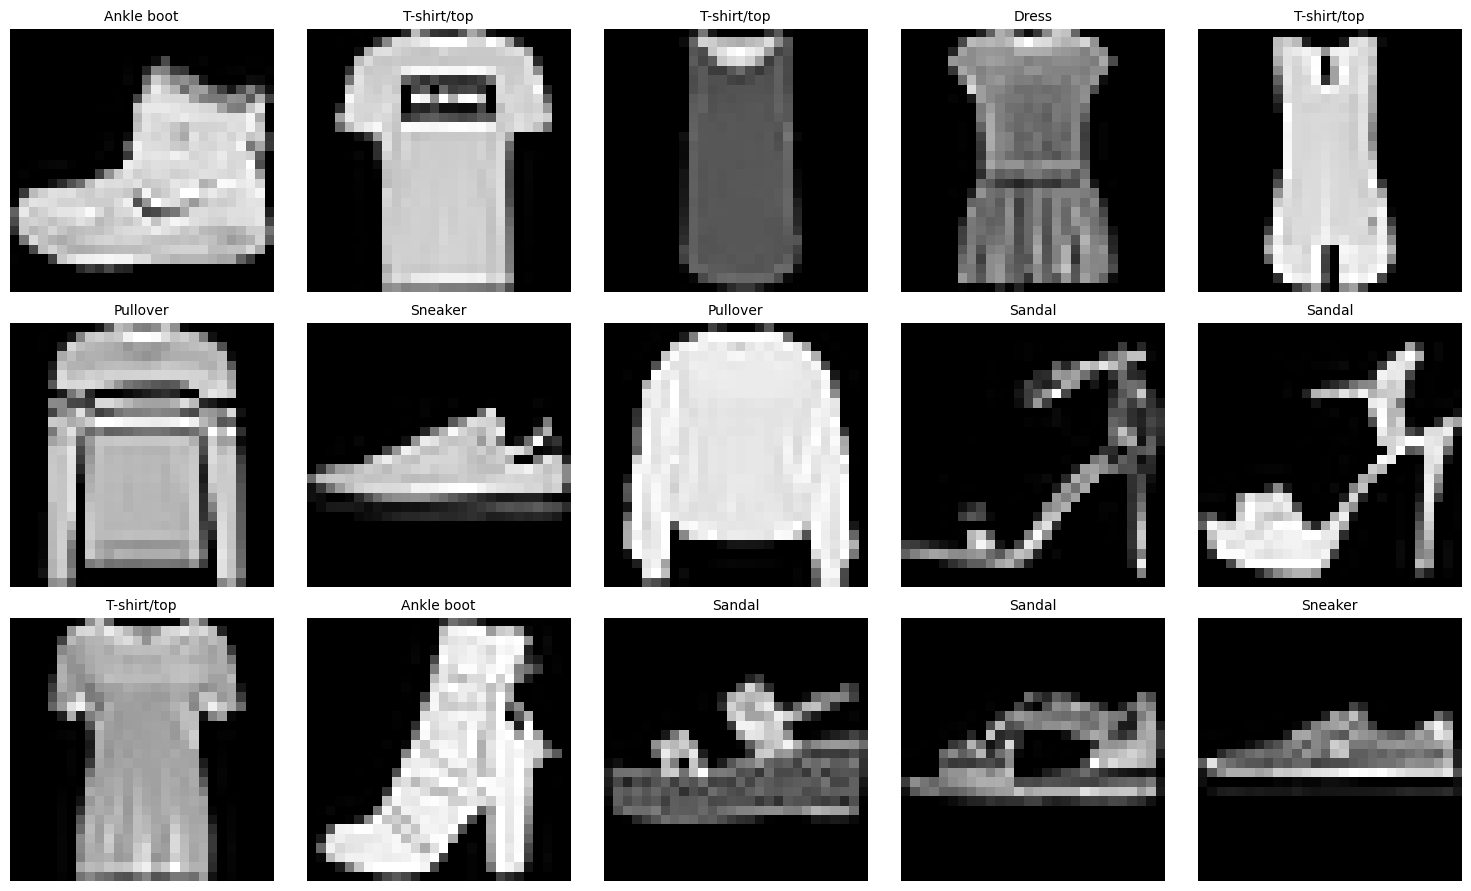

In [4]:
# 导入matplotlib用于绘图
import matplotlib.pyplot as plt
import matplotlib


# 创建一个3行5列的图表来显示前15个样本
plt.figure(figsize=(15, 9))  # 设置图表大小

# 遍历前15个样本
for i in range(15):
    # 创建子图
    plt.subplot(3, 5, i + 1)
    
    # 显示图像
    plt.imshow(train_images[i], cmap='gray')
    
    # 添加标题（显示类别名称）
    plt.title(class_names[train_labels[i]], fontsize=10)
    
    # 关闭坐标轴
    plt.axis('off')

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

# 数据集划分训练，验证以及设置3个加载器

In [5]:
# 设置随机种子以确保结果可复现
torch.manual_seed(42)

# 定义设备（GPU/CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 划分数据集为训练集和验证集
train_size = 55000
val_size = 5000

# 使用torch.utils.data.random_split函数接口划分数据集
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size, val_size]
)

print(f"训练集大小: {train_size}")
print(f"验证集大小: {val_size}")

# 创建数据加载器
batch_size = 64  # 批次大小

# torch.utils.data.DataLoader是PyTorch提供的一个数据加载器，用于将数据集划分为多个批次，并进行随机打乱和并行加载

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # 打乱数据
    num_workers=2,  # 多进程加载数据
    pin_memory=True  # 将数据加载到CUDA固定内存中，加速GPU训练
)

# 验证数据加载器
val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # 验证集不需要打乱
    num_workers=2,
    pin_memory=True
)
# 测试数据加载器
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)



训练集大小: 55000
验证集大小: 5000


# 定义并搭建模型

In [8]:
import torch.nn as nn
import torch.nn.functional as F


# 检查CUDA是否可用，如果可用则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

class NeuralNetwork(nn.Module):
    # 定义神经网络的结构
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        
        # 创建输入层到第一隐藏层 (784 -> 100)
        self.fc1 = nn.Linear(28 * 28, 100)
        self.bn1 = nn.BatchNorm1d(100)  # 第一层的批归一化
        nn.init.xavier_uniform_(self.fc1.weight)  # 使用Xavier均匀分布初始化权重
        
        # 创建19个隐藏层 (100 -> 100)，每层后面都加入批归一化
        self.hidden_layers = nn.ModuleList()
        for _ in range(19):
            self.hidden_layers.append(nn.Linear(100, 100))
            self.hidden_layers.append(nn.BatchNorm1d(100))  # 每个线性层后添加批归一化
        
        # 对所有隐藏层的线性层使用Xavier均匀分布初始化权重
        for i in range(0, len(self.hidden_layers), 2):  # 每隔2个取一个，即只取线性层
            nn.init.xavier_uniform_(self.hidden_layers[i].weight)
        
        # 输出层 (100 -> 10)
        self.fc_out = nn.Linear(100, 10)
        nn.init.xavier_uniform_(self.fc_out.weight)  # 输出层也使用Xavier均匀分布初始化

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 28 * 28]
        
        # 第一层
        x = self.fc1(x)
        x = self.bn1(x)  # 应用批归一化
        x = F.relu(x)
        
        # 19个隐藏层
        for i in range(0, len(self.hidden_layers), 2):
            x = self.hidden_layers[i](x)  # 线性层
            x = self.hidden_layers[i+1](x)  # 批归一化层
            x = F.relu(x)  # 激活函数
        
        # 输出层
        logits = self.fc_out(x)
        return logits



# 创建神经网络实列化模型
model = NeuralNetwork()
# 将模型移动到指定设备上
model = model.to(device)

# 从train_loader获取第一个批次的数据，dataiter是迭代器，images和labels是批次数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)

# 选择第一张图像进行前向传播测试,unsqueeze(0)是添加批次维度
test_image = images[0].unsqueeze(0).to(device)  # 添加批次维度并移动到设备上
print("测试图像形状:", test_image.shape)


使用设备: cpu
批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
测试图像形状: torch.Size([1, 1, 28, 28])


In [9]:

print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    # 在评估模式下运行模型，避免BatchNorm错误
    model.eval()
    outputs = model(test_image)
    # 恢复为训练模式
    model.train()

# 获取预测结果
_, predicted = torch.max(outputs, 1)
print("模型预测结果:", predicted.item())
print("实际标签:", labels[0].item())

----------------------------------------------------------------------------------------------------
模型预测结果: 3
实际标签: 7


# 计算参数量

In [10]:
# 计算模型的总参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {total_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

模型总参数量: 275410

各层参数量明细:
fc1.weight: 78400 参数
fc1.bias: 100 参数
bn1.weight: 100 参数
bn1.bias: 100 参数
hidden_layers.0.weight: 10000 参数
hidden_layers.0.bias: 100 参数
hidden_layers.1.weight: 100 参数
hidden_layers.1.bias: 100 参数
hidden_layers.2.weight: 10000 参数
hidden_layers.2.bias: 100 参数
hidden_layers.3.weight: 100 参数
hidden_layers.3.bias: 100 参数
hidden_layers.4.weight: 10000 参数
hidden_layers.4.bias: 100 参数
hidden_layers.5.weight: 100 参数
hidden_layers.5.bias: 100 参数
hidden_layers.6.weight: 10000 参数
hidden_layers.6.bias: 100 参数
hidden_layers.7.weight: 100 参数
hidden_layers.7.bias: 100 参数
hidden_layers.8.weight: 10000 参数
hidden_layers.8.bias: 100 参数
hidden_layers.9.weight: 100 参数
hidden_layers.9.bias: 100 参数
hidden_layers.10.weight: 10000 参数
hidden_layers.10.bias: 100 参数
hidden_layers.11.weight: 100 参数
hidden_layers.11.bias: 100 参数
hidden_layers.12.weight: 10000 参数
hidden_layers.12.bias: 100 参数
hidden_layers.13.weight: 100 参数
hidden_layers.13.bias: 100 参数
hidden_layers.14.weight: 10000 参数
hidde

# 分类设置交叉熵损失函数，SGD优化器

In [11]:
# 设置优化器 - SGD（随机梯度下降）
# 参数:
# - model.parameters(): 需要优化的参数
# - lr: 学习率，控制每次参数更新的步长
# - momentum: 动量因子，帮助加速收敛并减少震荡
# - weight_decay: L2正则化系数，防止过拟合
model = NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

print("损失函数:", loss_fn)
print("优化器:", optimizer)


损失函数: CrossEntropyLoss()
优化器: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5,delta=0.001) #早停
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True) #保存最好的模型

model, history = train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50,early_stopping=early_stopping,model_saver=model_saver)



使用设备: cpu


  0%|          | 0/46900 [00:00<?, ?it/s]

早停触发!
89.4000
早停: 已有5轮验证损失没有改善！


In [13]:
history['train'][-100:-1]

[{'loss': 0.3822212815284729, 'acc': 87.5, 'step': 12901},
 {'loss': 0.29525136947631836, 'acc': 87.5, 'step': 12902},
 {'loss': 0.13464267551898956, 'acc': 95.3125, 'step': 12903},
 {'loss': 0.3629138767719269, 'acc': 85.9375, 'step': 12904},
 {'loss': 0.11272838711738586, 'acc': 93.75, 'step': 12905},
 {'loss': 0.5828097462654114, 'acc': 87.5, 'step': 12906},
 {'loss': 0.31205064058303833, 'acc': 85.9375, 'step': 12907},
 {'loss': 0.24923723936080933, 'acc': 89.0625, 'step': 12908},
 {'loss': 0.23577147722244263, 'acc': 89.0625, 'step': 12909},
 {'loss': 0.2355380803346634, 'acc': 93.75, 'step': 12910},
 {'loss': 0.30788731575012207, 'acc': 82.8125, 'step': 12911},
 {'loss': 0.27491238713264465, 'acc': 92.1875, 'step': 12912},
 {'loss': 0.43604469299316406, 'acc': 89.0625, 'step': 12913},
 {'loss': 0.27403005957603455, 'acc': 93.75, 'step': 12914},
 {'loss': 0.39660781621932983, 'acc': 85.9375, 'step': 12915},
 {'loss': 0.40454959869384766, 'acc': 82.8125, 'step': 12916},
 {'loss': 0

In [14]:
history['val'][-10:-1]

[{'loss': 0.3437254649400711, 'acc': 87.54, 'step': 8500},
 {'loss': 0.34013248608112334, 'acc': 88.22, 'step': 9000},
 {'loss': 0.32780374381542204, 'acc': 88.8, 'step': 9500},
 {'loss': 0.33569783573150636, 'acc': 88.0, 'step': 10000},
 {'loss': 0.31337472414970396, 'acc': 89.4, 'step': 10500},
 {'loss': 0.3358123292446136, 'acc': 87.16, 'step': 11000},
 {'loss': 0.3391034296512604, 'acc': 88.06, 'step': 11500},
 {'loss': 0.29909080510139463, 'acc': 89.24, 'step': 12000},
 {'loss': 0.34837267265319827, 'acc': 87.26, 'step': 12500}]

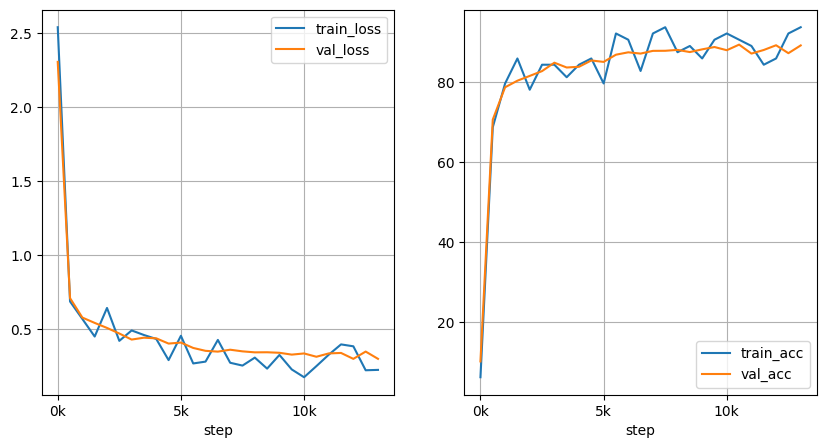

In [15]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [16]:
# 在测试集上评估模型
test_accuracy = evaluate(model, test_loader, device)
test_accuracy

(87.52, None)